## Gaussian Grid

To get the parameters for the gaussian grid, it has to be visualised. The main reason for this is that $\sigma$, $\beta$, and n do not have any physical units. 

In addition to the point of interest (latitude, longitude), the following parameters have to be picked:
- $\phi_{ini}$: initial distance between grid points, in degrees
- $\phi_{max}$: maximum distance between grid points, in degrees
- $\sigma$: size of the denser part of the grid.
- $\beta$: slope of the increase in grid point distance.
- n: number of points in the variable. 
- gamma: angle in degrees (i.e. area around center) in which the additional grid will be added
- dense antipole: Set to true if the grid should refocus at the antipole.
- only ocean: Set to true if gridpoints on land are to be removed
- blue marble: Adds an image of Earth to the plot. 

When a larger n is used, $\sigma$ also has to be increased. 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from GaussVoronoiGrid.scripts.source_grid_gauss import gauss_grid

In [2]:
# Pick a name for the grid
grid_name = 'GaussianGrid_Example'

# Pick values for the input variables

sigma = [20,20]
beta = [5,5]
phi_ini = [0.5,1]
phi_max = [3,5]
lat_0 = [46,-30]
lon_0 = [-33,50]
n = [200,200]
gamma = [0,20]
dense_antipole = False
only_ocean = True
blue_marble = True

Number of grids:  2
Grid 1 of 2
Minimum dx in m: 55741.699 m which is 0.5 °
Maximum dx in m: 334450.196 m which is 3.0 °
Number of gridpoints: 6825


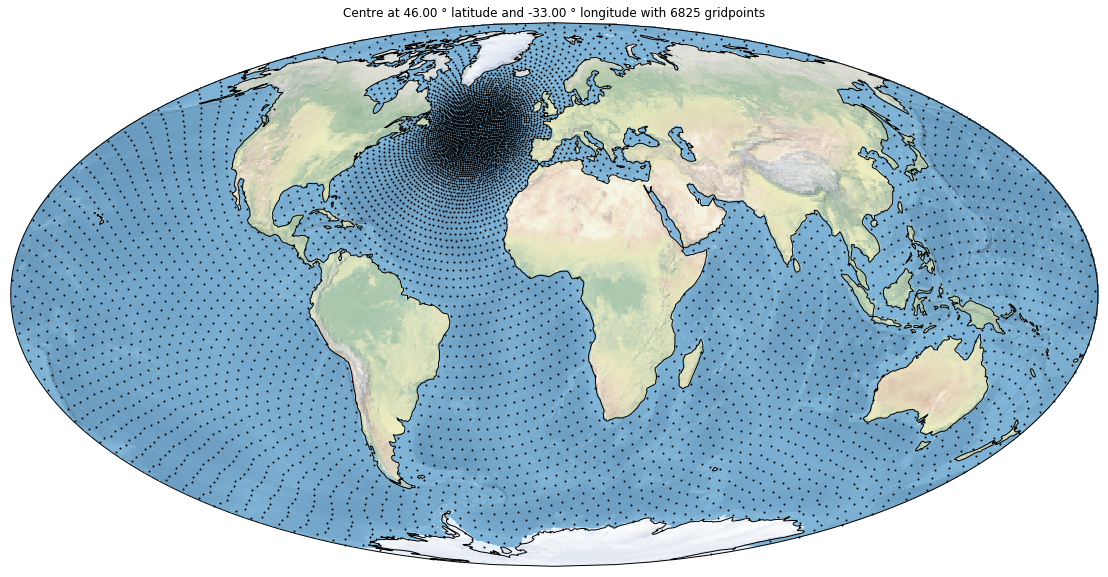

Grid 2 of 2
Minimum dx in m: 111667.092 m which is 1.0 °
Maximum dx in m: 558183.067 m which is 4.999 °
Number of gridpoints: 4291


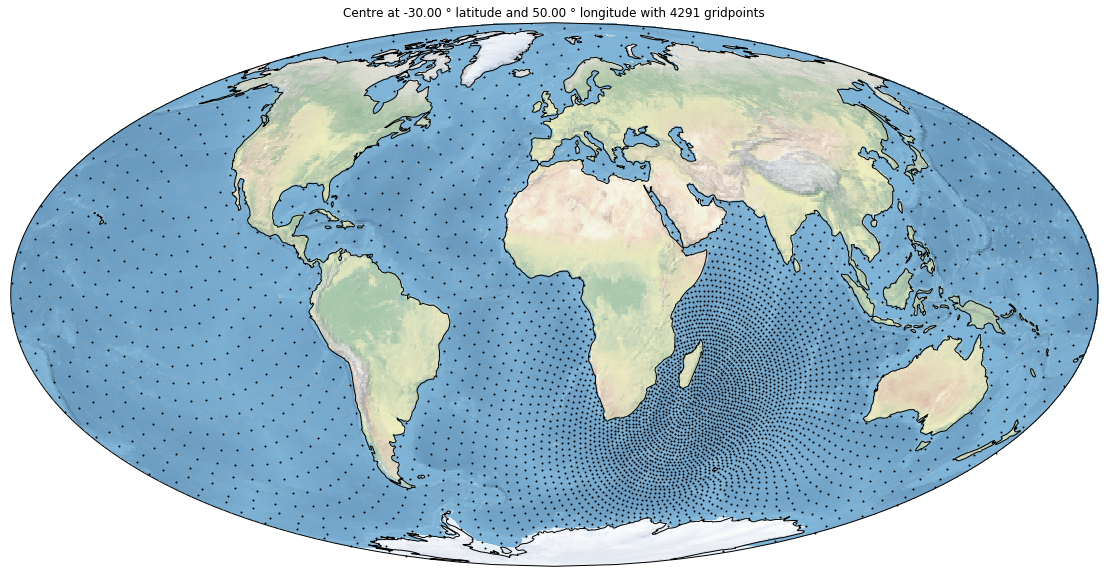

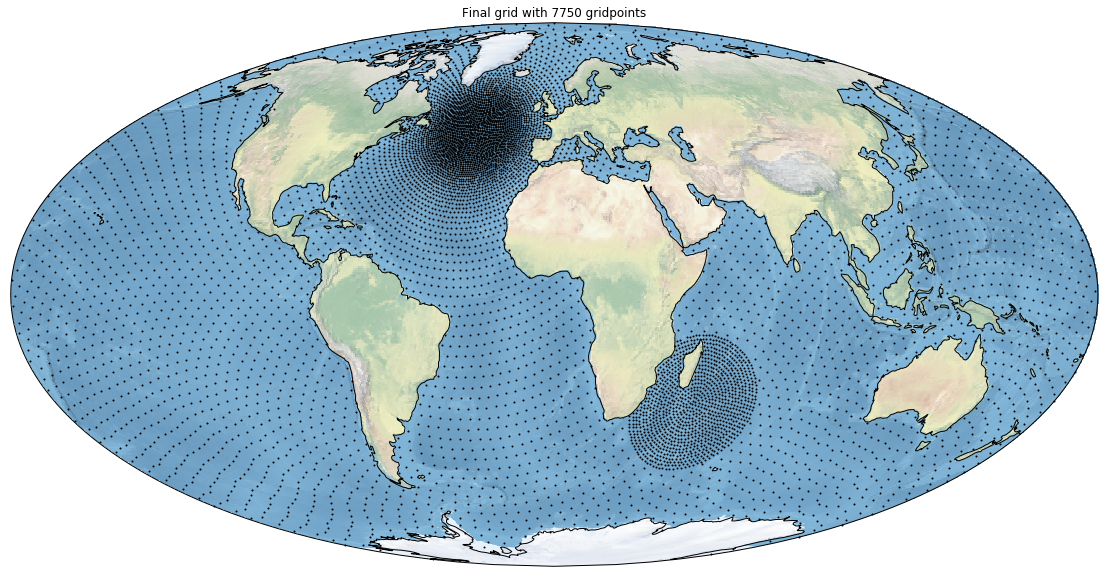

Final number of gridpoints: 7750


In [3]:
grid = gauss_grid(sigma,beta,phi_ini,phi_max,lat_0,lon_0,n,gamma,plot=True,dense_antipole = dense_antipole,only_ocean = only_ocean, blue_marble=blue_marble)

Sourcegrid saved as GaussianGrid_Example.npy in grids folder.


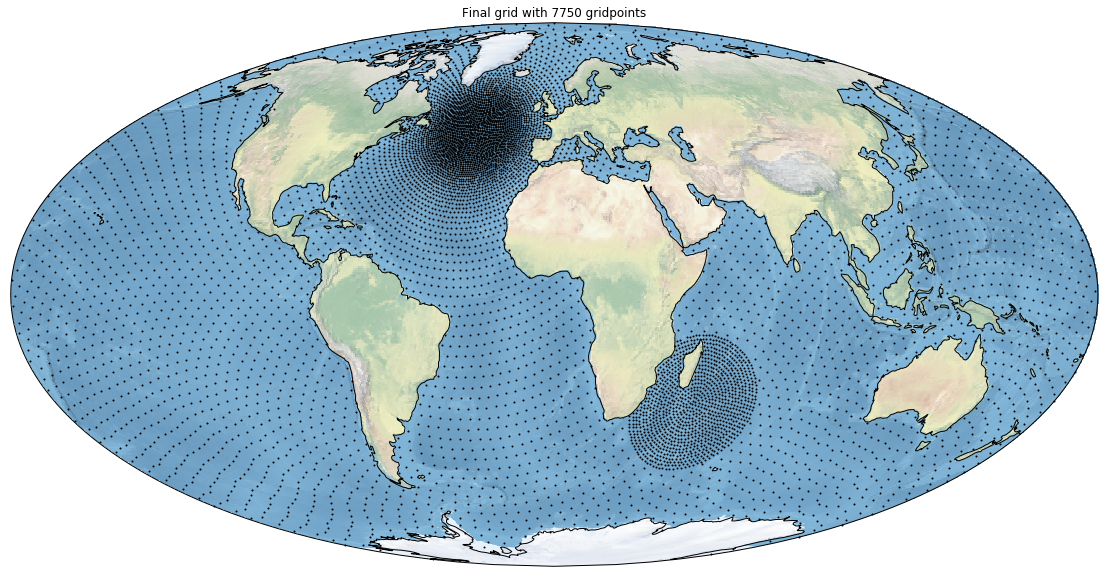

In [4]:
# write to .npy file in grids folder
np.save(os.path.join('./grids/',grid_name),grid)
print('Sourcegrid saved as %s.npy in grids folder.' %grid_name)

# save plot 
# Plot and save sourcegrid
plt.figure(figsize=(25,10))
ax = plt.axes(projection=ccrs.Mollweide())
ax.coastlines()
if blue_marble:
    ax.stock_img()
plt.scatter(grid[0],grid[1],s=1,c='k',transform=ccrs.Geodetic())
plt.title('Final grid with {} gridpoints'.format(np.size(grid[0])))
plt.savefig(os.path.join('./grids/',grid_name+'.png'))
plt.show()

# Voronoi Cells

After the grid is created and saved as a .npy we can compute the voronoi cells and calculate the voronoi cell surface area. As input we have the grid and as output the surface area corresponding to the voronoi cell of each grid point plus the grid, since the order might change.

In [5]:
import numpy as np
import os
import h5py
from GaussVoronoiGrid.scripts.voronoi_cells import get_voronoi_surface_area

In [6]:
## If only this is run set grid_name
grid_name = 'GaussianGrid_Example'

# import grid from grids folder
grid = np.load(os.path.join('./grids/',grid_name + '.npy'))

# Set below to True if Voronoi cells are to be plotted
### NOTE: THIS TAKES A LOT LONGER
voronoi_plot = False

Number of grids:  2
Grid 1 of 2
Grid 2 of 2
0 of 9781 voronoi cell surface areas calculated.
1000 of 9781 voronoi cell surface areas calculated.
2000 of 9781 voronoi cell surface areas calculated.
3000 of 9781 voronoi cell surface areas calculated.
4000 of 9781 voronoi cell surface areas calculated.
5000 of 9781 voronoi cell surface areas calculated.
6000 of 9781 voronoi cell surface areas calculated.
7000 of 9781 voronoi cell surface areas calculated.
8000 of 9781 voronoi cell surface areas calculated.
9000 of 9781 voronoi cell surface areas calculated.
All voronoi cell surface areas calculated.


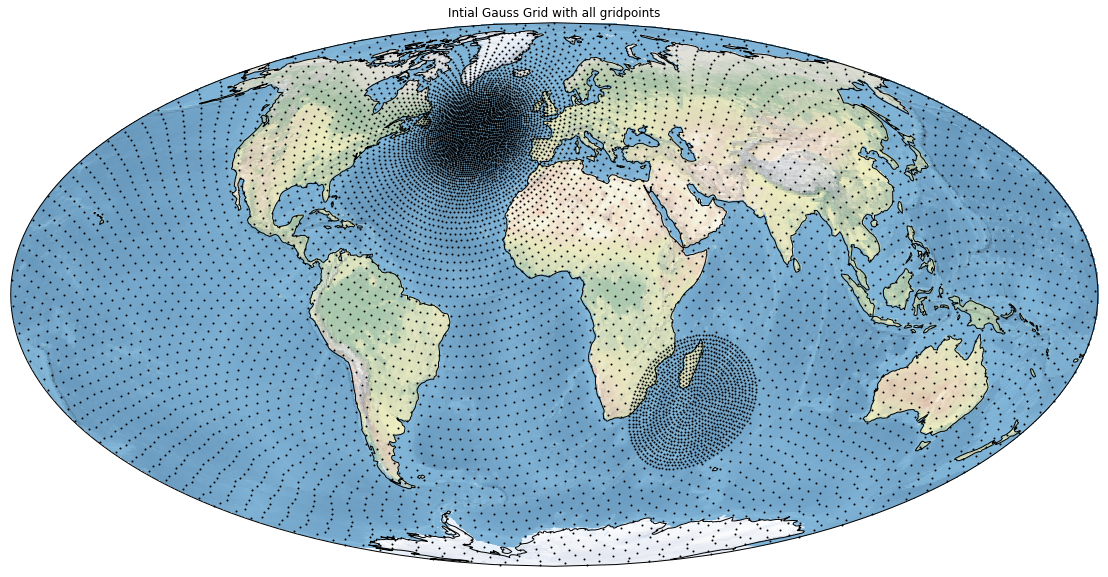

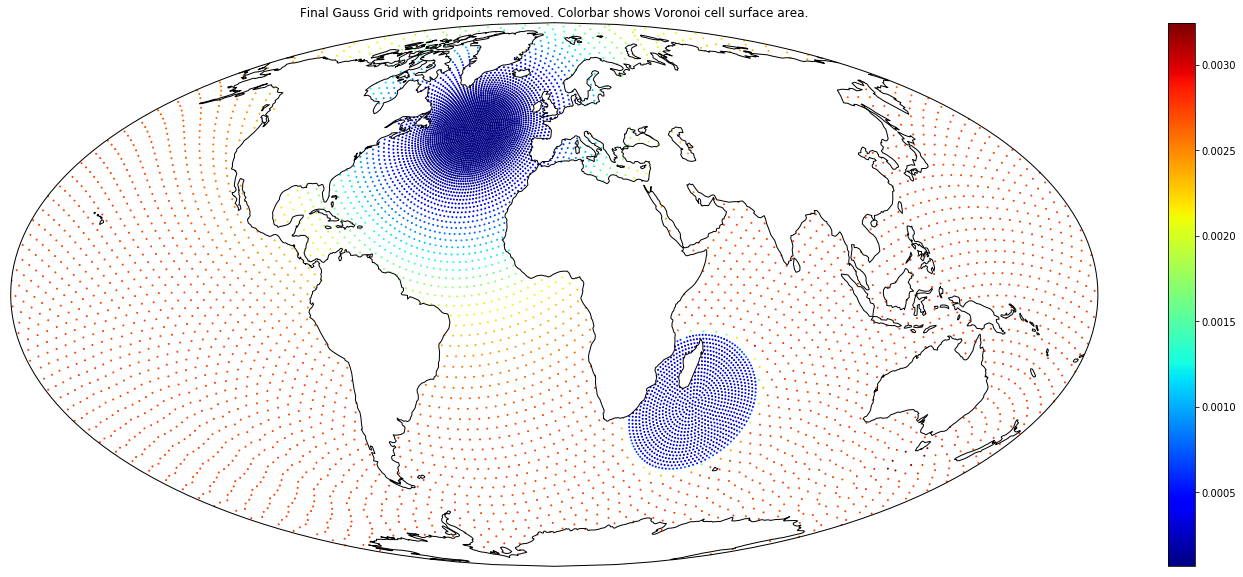

Gridpoints and voronoi cells on land removed.
Final number of gridpoints: 7750


In [7]:
# Need to calculate voronoi cell areas for only_ocean = False and then remove all from land

if only_ocean:
    
    n_grids = np.size(sigma)

    only_ocean_false = False

    plot_false = False

    # compute full grid with only_ocean = False
    grd_full = gauss_grid(sigma,beta,phi_ini,phi_max,
                  lat_0,lon_0,n,gamma,
                  plot=plot_false,dense_antipole=dense_antipole,
                  only_ocean=only_ocean_false,blue_marble=blue_marble)

    # Calculate voronoi cells for the whole grid
    grd, voronoi_areas = get_voronoi_surface_area(grd_full,voronoi_plot = voronoi_plot)

    # Plot
    plt.figure(figsize=(25,10))
    ax = plt.axes(projection=ccrs.Mollweide())
    ax.coastlines()
    if blue_marble:
        ax.stock_img()
    plt.scatter(grd[0],grd[1],s=1,c='k',transform=ccrs.Geodetic())
    plt.title('Intial Gauss Grid with all gridpoints')
    plt.show() 

    # Remove points on land again
    from GaussVoronoiGrid.scripts.cartopy_is_land import is_land
    grid_onlyocean_lon = []
    grid_onlyocean_lat = []
    voronoi_areas_onlyocean = []

    for i in range(0,np.size(grd[0])):
        if not is_land(grd[0][i],grd[1][i]):
            grid_onlyocean_lon.append(grd[0][i])
            grid_onlyocean_lat.append(grd[1][i])
            voronoi_areas_onlyocean.append(voronoi_areas[i])
        else:
            continue

    plt.figure(figsize=(25,10))
    ax = plt.axes(projection=ccrs.Mollweide())
    ax.coastlines()
    plt.scatter(grid_onlyocean_lon,grid_onlyocean_lat,s=1,c=voronoi_areas_onlyocean,transform=ccrs.Geodetic(),cmap=plt.get_cmap('jet'))
    plt.title('Final Gauss Grid with gridpoints removed. Colorbar shows Voronoi cell surface area.')
    plt.colorbar()
    plt.show() 

    print('Gridpoints and voronoi cells on land removed.')
    grd = np.asarray([grid_onlyocean_lon,grid_onlyocean_lat])
    voronoi_areas = np.asarray(voronoi_areas_onlyocean)
    print('Final number of gridpoints:', int(np.size(grd)/2))

else:
    grd, voronoi_areas = get_voronoi_surface_area(grd,voronoi_plot=voronoi_plot)

In [8]:
# Save grid and voronoi cell areas to .h5 file
with h5py.File(os.path.join('./grids/',grid_name + '.h5'),'w') as fh:
    fh.create_dataset('coordinates',data=grd.astype(np.float32))
    fh.create_dataset('voronoi_areas',data=voronoi_areas.astype(np.float32))